Note:
1. Make the statement `if 0 == 1` true to produce the results locally
2. For future improvement, code can be refactored into a data processing pipeline
3. For the purpose of this demo, I didn't care a lot about code efficiency or clean coding style

# 0. Load Data

In [1]:
%config Completer.use_jedi = False
import json
import re
import sys
import csv
import pandas as pd
import numpy as np
from datetime import timedelta, date
from itertools import groupby
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go

%matplotlib inline

In [2]:
with open('grammarly_data_exercise.json', 'r') as f:
    for num, line in enumerate(f):
        pass
    print('number of lines: {}'.format(num+1))

number of lines: 1


Looks like our json file is a large one-liner.
Let's see what a sample looks like

In [3]:
with open('grammarly_data_exercise.json', 'r') as f:
    print(f.read(200))

[{"date": "2016-02-29", "timestamp": 1456732801255, "uid": "g4Hjpoji4dmv", "isFirst": false, "utmSource": "Biznesowe+Rewolucje"}, {"date": "2016-02-29", "timestamp": 1456732801556, "uid": "g4Hjpoji4dm


Yep, it confirms that our file is a large json array in one line, instead of one ping per line. Althought the file is large, luckily I can still load it into memory. If the file gets any larger, I might need to split it into smaller chunks, then load into memory and process one chunk at a time.
```python
# split the file into smaller chunks, process it on the fly
with open('grammarly_data_exercise.json') as infile:
    temp = json.load(infile)
    chunkSize = 1000    # 1000 json records per file
    for i in range(0, len(temp), chunkSize):
        with open('split_files/file_' + str(i//chunkSize) + '.json', 'w') as outfile:
            json.dump(temp[i:i+chunkSize], outfile)
```

In [4]:
%%time
# load data into pandas DataFrame
if 0 == 1:
    with open('grammarly_data_exercise.json', 'r') as f:
        df = pd.DataFrame(json.load(f))
        df.to_csv('pings.csv', index=False)
else:
    df = pd.read_csv('pings.csv')
print('{} rows, {} columns'.format(df.shape[0], df.shape[1]))

4823567 rows, 5 columns
CPU times: user 5.31 s, sys: 736 ms, total: 6.04 s
Wall time: 6.52 s


In [5]:
df['date'] = pd.to_datetime(df['date'])
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df.head()

,date,isFirst,timestamp,uid,utmSource
0,2016-02-29,False,2016-02-29 08:00:01.255,g4Hjpoji4dmv,Biznesowe+Rewolucje
1,2016-02-29,False,2016-02-29 08:00:01.556,g4Hjpoji4dmv,Biznesowe+Rewolucje
2,2016-02-29,False,2016-02-29 08:00:01.770,75121338,program
3,2016-02-29,False,2016-02-29 08:00:03.129,11l0tD2wFPFO,NaN
4,2016-02-29,False,2016-02-29 08:00:03.610,56429432,NaN


# 1. Daily Active Users (DAU)
Show the daily active users over the month, including all users. A user is considered active if they pinged at least once on a given day.

In [6]:
%%time
all_days = np.unique(df['date'])
all_days = pd.DatetimeIndex(all_days).date # get the date part from numpy.datetime64 data type
DAU = {}
if 0 == 1:
    for day in all_days:
        DAU[day] = np.unique(df[df['date'] == day].loc[:, 'uid']) # get unique users for each day
        pd.Series(DAU[day]).to_csv('DAU_by_day/DAU-' + str(day) + '.csv', index=False)
else:
    for day in all_days:
        DAU[day] = pd.read_csv('DAU_by_day/DAU-' + str(day) + '.csv', squeeze=True)

CPU times: user 1.86 s, sys: 248 ms, total: 2.11 s
Wall time: 2.2 s


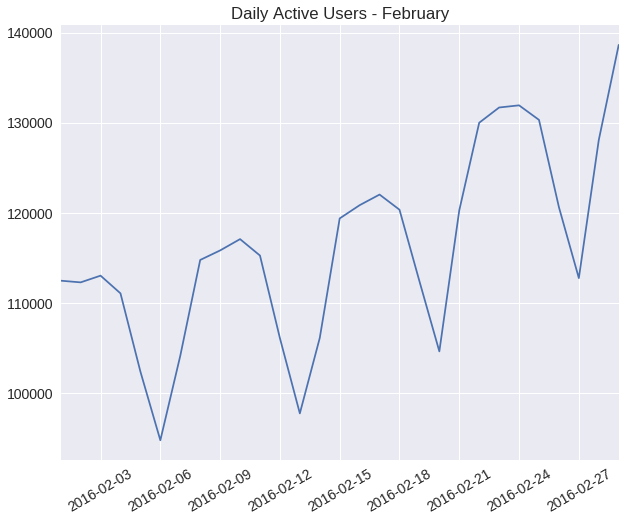

In [7]:
daily_active_counts = {}
for key, val in DAU.items():
    daily_active_counts[key] = val.shape[0]
dau = pd.Series(daily_active_counts)
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(10,8))
dau.plot()
plt.title('Daily Active Users - February')
plt.xticks(rotation=30);

Two interesting things:
1. A very clear up-and-down pattern. Specifically, down times are Fridays, Saturdays, and Sundays, with Saturdays at the bottom of valley.
2. A also very clear growing trend at February. In other words, our user base is growing.

# 2. Daily Retention Curve
Calculate the daily retention curve for users who used the app for the first time on the following dates: Feb 4th, Feb 10th, and Feb 14th. Also, show the number of users from each cohort.

Daily retention curve is defined as the % of users from the cohort, who used the product that day

In [8]:
# find cohort of users who first used app on Feb 4th, Feb 10th, and Feb 14th
cohort = {}
def range_date(start, end):
    delta = end - start
    for n in range(delta.days + 1):
        yield start + timedelta(n)

# calculate daily retention rate for each cohort
def retention_rate(start_date):
    end_date = date(2016,2,29)
    # the cohort who first time used our app on given date
    cohort = df[(df['isFirst']==True) & (df['date']==start_date)].loc[:, 'uid']
    ret_rates = {}
    for day in range_date(start_date, end_date):
        count_day = len(set(cohort) - (set(cohort) - set(DAU[day])))
        ret_rates[day] = count_day / cohort.shape[0] * 100
    return ret_rates

In [9]:
rates = {}
for day in [date(2016,2,4), date(2016,2,10), date(2016,2,14)]:
    rates[day] = retention_rate(day)

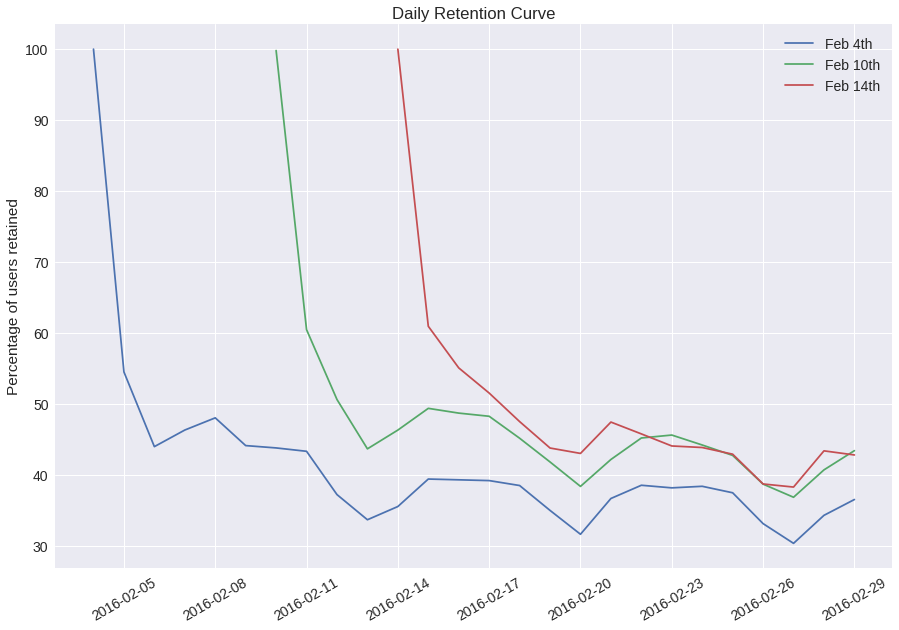

In [10]:
# get retention data for each of the dates: Feb 4th, Feb 10th, and Feb 14th
sns.set(font_scale=1.4)
fig, ax = plt.subplots(figsize=(15,10))
plt.xticks(rotation=30)
plt.plot(pd.DataFrame(rates))
ax.legend(['Feb 4th', 'Feb 10th', 'Feb 14th'])
ax.set_title('Daily Retention Curve')
ax.set_ylabel('Percentage of users retained');

### Findings

1. Similarly with DAU plot, all three retention curves follow the same repeated up-and-down pattern.
2. On average, Day 1 retention rate is at 55% - 60%, Day 7 retention rate is at 45% - 50%, Day 15 retention rate is at 38% - 42%.
3. The Feb 10th and Feb 14th cohorts are doing better than the Feb 4th cohort, probably a new feature added to the app, or a reduce on app latency, whatever it is, it's helping retain more users!

# 3. Source Analysis
Determine if there are any differences in usage based on where the users came from. From which traffic source does the app get its best users? Its worst users?

In [11]:
num_ping = df.shape[0]
num_NA_source = df.isnull().sum(axis=0)[4]
print('There are {} pings in total, {} of which have a null source, dropped'.format(num_ping, num_NA_source))

# drop rows with null sources
df = df.dropna()
sources = df['utmSource'].unique()
sources.sort()
print('There are {} different sources of pings'.format(df['utmSource'].nunique()))

There are 4823567 pings in total, 1674386 of which have a null source, dropped
There are 52 different sources of pings


## 3.1 Usage Difference
Compare app usage for different sources with number of daily active users

In [12]:
def get_avg_dau(data):
    dau = [data[data['date']==day]['uid'].unique().shape[0]
                  for day in all_days]
    return np.mean(dau)

In [13]:
daily_users, monthly_users = {}, {}
for source in sources:
    data = df[df['utmSource']==source] # filter out pings that are from given source
    daily_users[source] = get_avg_dau(data)

In [14]:
# average daily active user
values = pd.Series(daily_users)
trace = go.Pie(labels=sources, values=values)
py.iplot([trace], filename='Average DAU')

So 58% of our users come from *Biznesome+Rewolucje*, 11% from *program*, 9% from *answers*, etc. The MAU breakdown also gives similar result.

## 3.2 Where do the best users come from?
What differentiates a good user from a bad user for our app? Generally, a good user is someone who **visits our app more often**, spends more time in our app, and generate more revenue for us.

From the February ping data, we can quickly find out the number of active days in a month for each user, as well as the number of ping times (frequency) per day. Since ultimately we want to find out which source do the users come from, **pings with null sources are not considered here**. In other words, we cannot use the DAU result calculated in section 1.

### Find Good Users and Bad Users
Note I assume that the pings from different sources must come from different user ids. Even for the same user, we will assign him a different uid for different sources. That means **given a uid, there will be one and only one sources** associated with it

In [15]:
%%time
if 0 == 1:
    # aggregate number of pings per user per day
    agg = df.groupby(['uid','date','utmSource']).size()

    # get ping times per day, active days in a month, and sources for each user
    uids = agg.index.get_level_values('uid').unique()
    user_pings_per_day, user_active_days, user_source = {}, {}, {}
    for uid in uids:
        temp = agg.xs(uid)
        user_pings_per_day[uid] = np.mean(temp)
        user_active_days[uid] = len(temp)
        user_source[uid] = temp.index.get_level_values('utmSource')[0]
    df_user = pd.concat([
                            pd.Series(user_pings_per_day, name='times_per_day'),
                            pd.Series(user_active_days, name='days_per_month'),
                            pd.Series(user_source, name='source')
                        ], axis=1)
    df_user.to_csv('user_eval.csv')
else:
    df_user = pd.read_csv('user_eval.csv', index_col=0)

CPU times: user 196 ms, sys: 4 ms, total: 200 ms
Wall time: 214 ms


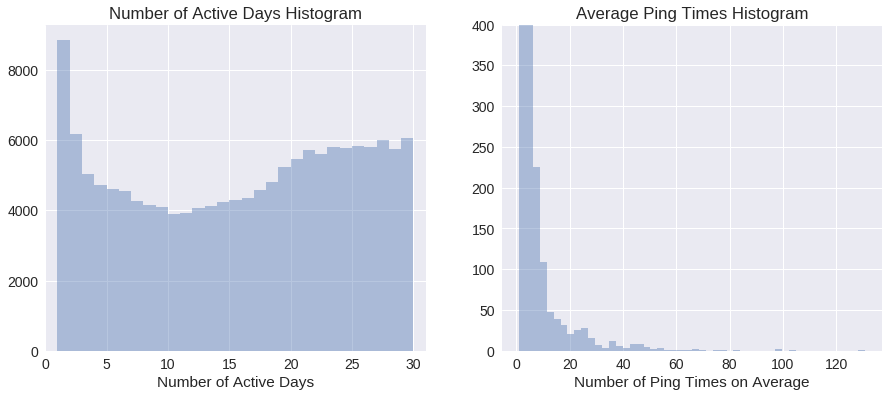

In [16]:
sns.set(font_scale=1.4)
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(15,6))
sns.distplot(df_user['days_per_month'], kde=False, ax=ax0)
ax0.set_xlim(0,31)
ax0.set_xlabel('Number of Active Days')
ax0.set_title('Number of Active Days Histogram')

sns.distplot(df_user['times_per_day'], kde=False, ax=ax1)
ax1.set_ylim(0, 400)
ax1.set_xlabel('Number of Ping Times on Average')
ax1.set_title('Average Ping Times Histogram');

According to the distribution of users' active days, they are basically evenly distributed all over the place. The number of users who use the app twice a month is pretty much the same with the number of users who use the app 25 times a month.

But when looking at the number of times a user uses the app in a day, the vast majority of them uses the app only once or twice a day (88.5%, in which 30.4% uses once, 58% uses twice).

### Findings
Let's say **a typical good user is active at least for 25 days and uses the app at least 3 times a day**. **A bad user is active for less than 5 days and only uses the app for 1 time a day** (I admit, this is not a good metric to label bad users).

---

In [17]:
cond1 = (df_user['days_per_month'] >= 25) & (df_user['times_per_day'] >= 3)
cond2 = (df_user['days_per_month'] < 5) & (df_user['times_per_day'] == 1)
print('{} users in total'.format(df_user.shape[0]))
print('{} good users selected'.format(df_user[cond1].shape[0]))
print('{} bad users selected'.format(df_user[cond2].shape[0]))
good, bad = df_user[cond1], df_user[cond2]
good = good.groupby('source').size().sort_values()
bad = bad.groupby('source').size().sort_values()
good, bad = good / np.sum(good) * 100, bad / np.sum(bad) * 100

147737 users in total
1140 good users selected
7623 bad users selected


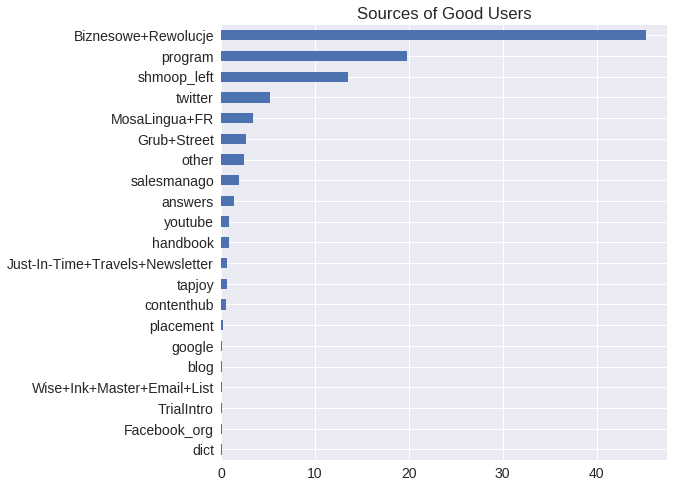

In [18]:
sns.set(font_scale=1.4)
good.plot(kind='barh', figsize=(8,8))
plt.ylabel('')
plt.title('Sources of Good Users');

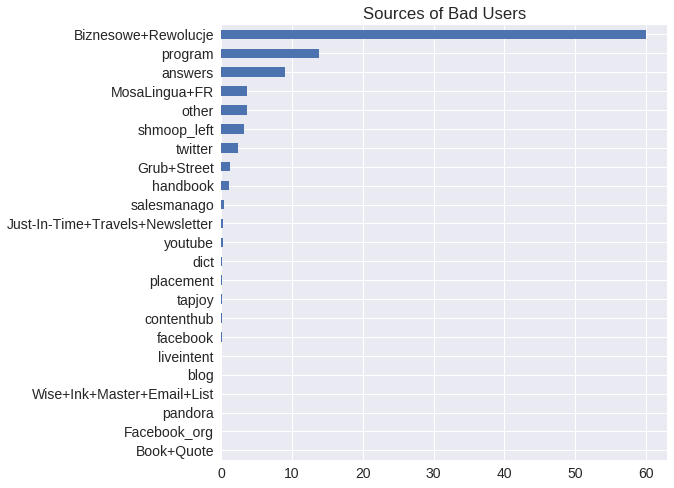

In [19]:
bad.plot(kind='barh', figsize=(8,8))
plt.ylabel('')
plt.title('Sources of Bad Users');

Apparently, due to the reason that lots of the pings come from Biznesowe+Rewolucje and program, we can expect them to carry lots of good users and bad users.

In [20]:
[good.tail(10), bad.tail(10)]

[source
 youtube                 0.877193
 answers                 1.403509
 salesmanago             1.929825
 other                   2.456140
 Grub+Street             2.631579
 MosaLingua+FR           3.421053
 twitter                 5.263158
 shmoop_left            13.508772
 program                19.824561
 Biznesowe+Rewolucje    45.263158
 dtype: float64, source
 salesmanago             0.419782
 handbook                1.075692
 Grub+Street             1.272465
 twitter                 2.413748
 shmoop_left             3.227076
 other                   3.659976
 MosaLingua+FR           3.659976
 answers                 9.025318
 program                13.826577
 Biznesowe+Rewolucje    59.989505
 dtype: float64]

### Findings
Among our selected group of good users, bad users: 

1. As two big players, *Biznesowe+Rewolucje* produces 45% of good users and 60% of bad users, while *program* produces 20% of good users and only 14% of bad users
2. A bad source: *answers* produces 1.4% of good users and 9.0% of bad users 
3. A good source: *shmoop_left* produces 13.5% of good users and only 3.2% of bad users. Cheers! 

A side note, to measure how good a source is to our app, another thing we could do here is to check the retention rate for each source, e.g. Average Day 1 Retention Rate and Average Day 7 Retention Rate.

# 4. My Thoughts
Separate from the data analysis, it would be great to hear your thoughts on the Grammarly product and what data-related projects/ideas you think we should be pursuing.

I like Grammarly, the interface is clean, very easy to use. And more importantly it is fast and helpful correcting my spell errors. I have it installed as a chrome extension, but I know Grammarly is doing much more than being a browser extension. 

Ultimately Grammarly is helping user check grammar errors automatically. Where can it be applied? Anywhere that has a text box! Like Twitter comment area, final project writeup at school, formal document for work etc. Grammaly provides lots of services and products now, like Grammarly EDU, Grammarly for business, Grammarly for MS Office etc.

These products are great, and I'm sure Grammarly will continue expanding to cover more areas/platforms, like iWork on Mac, and LibreOffice on Linux etc. Probably expand to other languages as well. Anyhow, here are my thoughts on the products.

First of all, there are competitors out there, we have to be better than other grammar checker, how? I believe the key is personalization. Not just personal dictionary, personal setting sort of personalization, which is great. But I think Grammarly could push this a little bit further.

With the help of cutting-edge Machine Learning, especially Natural Language Processing techniques, there will be computer-generated pieces of articles, news, documents etc. showing up on the Internet. 

**Since Grammarly has this huge amount of user data, instead of suggesting words for correction, why not take one step further, suggesting sentences or even generating a whole paragraph for users? To make it even better, Grammarly can also add a sense of his/her writing style to it, if Grammarly sees enough of his/her previous work.**

**For now, start with Premium users, or users with writing-intensive needs, like columnists, jouralists, even just bloggers. This may sound bold for now, but it will help Grammaly establish its leading position in the field if Grammarly is willing to take the initiative.**

Right now, Grammarly's core business is still grammar checking, but it can start on other businesses once they have enough resourses (essentially data and money). Think about LinkedIn, it started as a tool for people to build and maintain professional connections. When it accumulated enough of users, it started to attract attentions of big companies who desire for talented employee, recruiting agencies who want to gain access to profiles of job hunters, and many others. Now come back to Grammarly, the most invaluable asset is the data collected from user who uses Grammarly's products. **Once the data is acquired, there are a lot of things Grammarly can do, for example profiling users into different groups for better ads targeting, or providing tips or directing them to the approriate training agencies. Or even start a business to teach foreigners to learn English.**